In [18]:
import pandas as pd
import numpy as np
from pvlib.location import Location

# Definicja miast
cities = {
    'plant_name': ['Warszawa', 'Kraków', 'Łódź', 'Wrocław', 'Poznań', 'Gdańsk', 'Szczecin', 'Bydgoszcz', 'Lublin', 'Katowice'],
    'latitude': [52.2297, 50.0647, 51.7592, 51.1079, 52.4064, 54.3520, 53.4285, 53.1235, 51.2465, 50.2709],
    'longitude': [21.0122, 19.9450, 19.4576, 17.0385, 16.9252, 18.6466, 14.5528, 18.0076, 22.5684, 19.0238],
    'altitude': [100, 220, 162, 120, 83, 7, 5, 60, 170, 260],
    'tz': ['Europe/Warsaw'] * 10
}

cities_df = pd.DataFrame(cities)

# Zakres czasowy (np. jeden dzień)
times = pd.date_range('2024-01-01', '2024-12-31 23:00:00', freq='1H', tz='Europe/Warsaw')
num_hours = len(times)

# Generowanie danych o zachmurzeniu (wartości od 0 do 1)
cloudiness_data = {city: np.random.rand(num_hours) for city in cities_df['plant_name']}
cloudiness_data['time'] = times
cloudiness_df = pd.DataFrame(cloudiness_data)

# Funkcja do dostosowania irradiancji na podstawie zachmurzenia
def adjust_for_cloudiness(ghi, dni, dhi, cloudiness):
    dni_adj = dni * (1 - cloudiness)
    dhi_adj = dhi * (1 + cloudiness * 0.5)
    ghi_adj = dni_adj + dhi_adj
    return ghi_adj, dni_adj, dhi_adj

# Pętla obliczeniowa dla każdego miasta
daily_energy_results = []

for index, city in cities_df.iterrows():
    location = Location(city['latitude'], city['longitude'], city['tz'], city['altitude'])
    clearsky = location.get_clearsky(times, model='ineichen')
    
    cloudiness = cloudiness_df[city['plant_name']].values
    
    ghi_adj_list = []
    cloudiness_list = []
    
    for i in range(num_hours):
        ghi_adj, _, _ = adjust_for_cloudiness(
            clearsky['ghi'].values[i], clearsky['dni'].values[i], clearsky['dhi'].values[i], cloudiness[i]
        )
        ghi_adj_list.append(ghi_adj)
        cloudiness_list.append(cloudiness[i])
    
    # Tworzenie DataFrame dla miasta z czasem, ghi_adj, cloudiness
    city_results = pd.DataFrame({
        'time': times,
        'plant_name': city['plant_name'],
        'ghi_adj': ghi_adj_list,
        'cloudiness': cloudiness_list
    })
    
    # Grupowanie po dacie i obliczanie dziennej energii oraz średniego zachmurzenia
    city_daily_energy = city_results.groupby(city_results['time'].dt.date).agg({
        'ghi_adj': 'sum',
        'cloudiness': 'mean'
    }).reset_index()
    city_daily_energy.columns = ['date', 'daily_energy_Wh_per_m2', 'average_daily_cloudiness']
    city_daily_energy['plant_name'] = city['plant_name']
    
    daily_energy_results.append(city_daily_energy)

# Poza pętlą łączymy wyniki
daily_energy_df = pd.concat(daily_energy_results, ignore_index=True)

# Wyświetlanie wyników
print(daily_energy_df)


C:\Users\Airly\AppData\Local\Temp\ipykernel_24496\1453302699.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range('2024-01-01', '2024-12-31 23:00:00', freq='1H', tz='Europe/Warsaw')


            date  daily_energy_Wh_per_m2  average_daily_cloudiness plant_name
0     2024-01-01             1267.232208                  0.405629   Warszawa
1     2024-01-02             2198.215102                  0.428108   Warszawa
2     2024-01-03             2044.215515                  0.512950   Warszawa
3     2024-01-04             1879.569731                  0.538056   Warszawa
4     2024-01-05             1879.044698                  0.532981   Warszawa
...          ...                     ...                       ...        ...
3655  2024-12-27             1527.551232                  0.616317   Katowice
3656  2024-12-28             2270.708489                  0.502939   Katowice
3657  2024-12-29             2060.047917                  0.428089   Katowice
3658  2024-12-30             1505.917415                  0.619776   Katowice
3659  2024-12-31             1845.343267                  0.474203   Katowice

[3660 rows x 4 columns]


<AxesSubplot:>

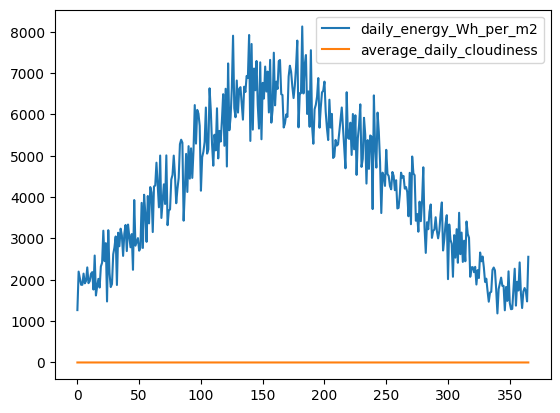

In [20]:
daily_energy_df[daily_energy_df.plant_name == 'Warszawa'].plot()